In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils
import matplotlib.ticker as ticker
import os

# Set default dtype for torch
torch.set_default_dtype(torch.float64)

plt.rcParams.update({
    "text.usetex": False, 
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman", "DejaVu Serif", "Bitstream Vera Serif"],
    "mathtext.fontset": "cm" 
})

In [2]:
# Define simulation parameters
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}
b0 = torch.ones(N)
b1 = torch.ones(N)
sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [3]:
# Specify delta and generate Wyy
mu = 0.0
delta = 0.1  # Adjust delta as desired

In [4]:
# Define the time vector for simulation
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max = max(torch.max(tauA), torch.max(tauY))
chunk_time = 1000 * tau_max
dt = 0.05 * tau_min
points = int(chunk_time / dt)
t_chunk = torch.linspace(0, chunk_time, points)

In [5]:
# Model setup
model_name = 'delocalized'
input_norm = 0.01
initial_type = 'zero'

z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)

### Trajectory of the first y neurons across trials

In [6]:
# Helper: compute when a neuron's changes become consistently small
def find_convergence_time(neuron_traj, t_chunk, epsilon=1e-4, window=20):
    diffs = torch.abs(neuron_traj[1:] - neuron_traj[:-1])
    for i in range(len(diffs) - window + 1):
        if torch.all(diffs[i:i+window] < epsilon):
            return t_chunk[i]
    return t_chunk[-1]  # if never converged, assign final time

# Helper: for each neuron, compute convergence time and pick the one with the maximum time
def find_slowest_neuron(traj, t_chunk, epsilon=1e-4, window=20):
    conv_times = [find_convergence_time(traj[:, i], t_chunk, epsilon, window) for i in range(N)]
    # return both the max time and the index of the neuron
    max_time = max(conv_times)
    max_index = conv_times.index(max_time)
    return max_time, max_index

In [7]:
n_trajectories = 1  # Desired number of accepted trajectories

all_traj_data = []  # List to store all trajectory data

trajectories_idx = []  # List to store accepted trajectory data

accepted = 0  # Counter for accepted trajectories

threshold = -1e3  # Threshold for the slowest neuron


while accepted < n_trajectories:
    Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)
    model = organics.ORGaNICs2Dgeneral(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z,
        initial_type=initial_type,
        run_jacobian=False,
    )
    sim_obj = sim_solution(model)
    # Each trajectory uses a fresh initial condition
    y0 = model.inital_conditions(initial_type=initial_type)
    traj = sim_obj.simulate(t_chunk, y0=y0)
    
    slowest_time, slow_idx = find_slowest_neuron(traj, t_chunk, epsilon=1e-5, window=100)
    print(f"Slowest time: {slowest_time / chunk_time:.4f}")
    # Store the accepted trajectory data
    if slowest_time < 0.3 * chunk_time or traj[-1, slow_idx] < threshold:
        continue
    trajectories_idx.append(traj[:, slow_idx].detach().numpy())
    all_traj_data.append(traj)
    accepted += 1
    print(accepted)

Slowest time: 0.1312
Slowest time: 0.1426
Slowest time: 0.1874
Slowest time: 0.1730
Slowest time: 0.2221
Slowest time: 0.1691
Slowest time: 0.2075
Slowest time: 0.1879
Slowest time: 0.2447
Slowest time: 0.1739
Slowest time: 0.2306
Slowest time: 0.2268
Slowest time: 0.2511
Slowest time: 0.1623
Slowest time: 0.1568
Slowest time: 0.1574
Slowest time: 0.3002
1


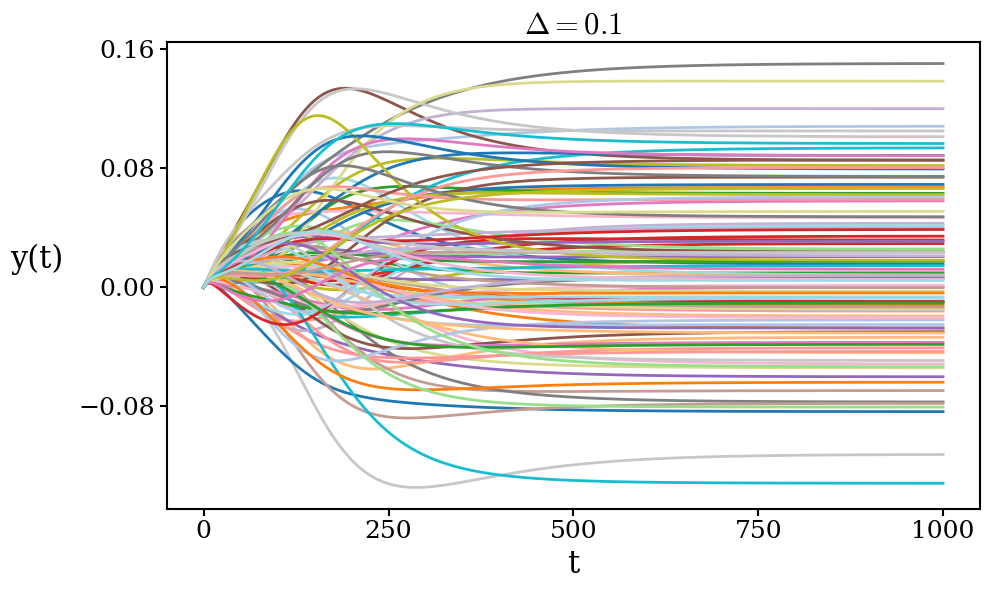

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.get_cmap("tab20")

for neuron in range(N):
    ax.plot(
        t_chunk.numpy() / 0.002,
        traj[:, neuron].detach().numpy(),
        linewidth=2.0,
        label=f'Neuron {neuron}',
        color=colors(neuron % 20)
    )

# Labels and title
ax.set_xlabel("t", fontsize=22)
ax.set_ylabel("y(t)", fontsize=22, rotation=0, labelpad=30)  # rotate to 0° (horizontal)
# ax.yaxis.set_label_coords(-0.1, 0.5)                       # shift it out to the left
ax.set_title(rf"$\Delta = {delta}$", fontsize=22)

# Thicken ticks and make them longer
ax.tick_params(
    axis='both',
    which='major',
    labelsize=18,
    width=1.5,    # tick thickness
    length=5.0    # tick length
)

# Limit number of ticks for clarity
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

# Thicken the axes boundary (spines)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

plt.tight_layout()

# Save the figure (adjust the folder and file names as needed)
folder_loc = f'../figures/mu_{mu}/fig_all_neuron_trajectories'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'neuron_trajectories_single_trial_{delta}'
file_save_path = os.path.join(folder_loc, file_name)

for ext in ("png", "svg", "eps"):
    plt.savefig(f'{file_save_path}.{ext}', format=ext, bbox_inches='tight', dpi=300)

plt.show()

In [9]:
# # Now, plot the stored trajectories on a single figure
# plt.figure(figsize=(10, 6))
# colors = plt.get_cmap("tab10")

# for i, traj_data in enumerate(trajectories_idx):
#     plt.plot(t_chunk.numpy() / 0.002, traj_data, linewidth=2.5, label=f'Trajectory {i+1}', color=colors(i))

# # Set labels and title with the same font sizes as before
# plt.xlabel("Time", fontsize=22)
# plt.ylabel(f"Slowest y neuron", fontsize=22)
# plt.title(f"Trajectories for delta = {delta}", fontsize=22)
# plt.xticks(fontsize=22)
# plt.yticks(fontsize=22)
# # Limit to only 4 ticks on x axis
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
# plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

# # plt.legend(fontsize=12)

# # Create folder and file save paths similar to the histogram code
# folder_loc = f'../figures/mu_{mu}/fig_trajectories'
# os.makedirs(folder_loc, exist_ok=True)
# file_name = f'trajectories_{delta}'
# file_save_path = os.path.join(folder_loc, file_name)
# # plt.xlim(0, 600)

# plt.tight_layout()
# plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
# plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
# plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
# plt.show()

### Trajectory of all the neurons for a given trial

In [55]:
# Single trial simulation for all neurons
Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)
model = organics.ORGaNICs2DgeneralRectifiedRecurrence(
    params=params,
    b0=b0,
    b1=b1,
    sigma=sigma,
    tauA=tauA,
    tauY=tauY,
    Wyy=Wyy,
    Way=Way,
    z=z,
    initial_type=initial_type,
    run_jacobian=False,
)
sim_obj = sim_solution(model)
# Use a fresh initial condition for the trial
y0 = model.inital_conditions(initial_type=initial_type)
traj = sim_obj.simulate(t_chunk, y0=y0)

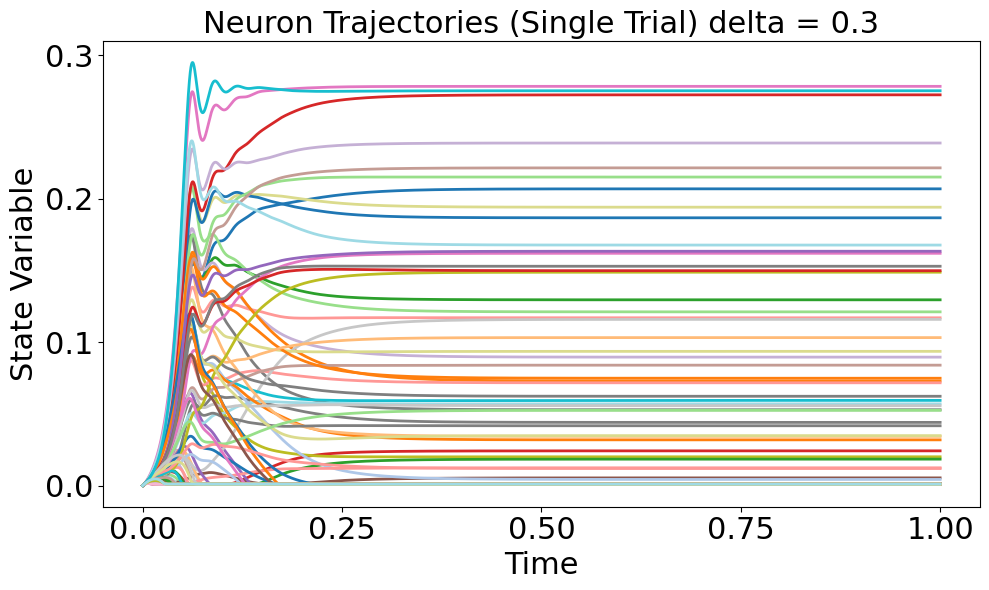

In [11]:

# Plot trajectories for all neurons on the same figure
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab20")

for neuron in range(N):
    # Cycle through colors if N > 10
    plt.plot(t_chunk.numpy(), traj[:, neuron].detach().numpy(), linewidth=2.0,
             label=f'Neuron {neuron}', color=colors(neuron % 20))

plt.xlabel("Time", fontsize=22)
plt.ylabel("State Variable", fontsize=22)
plt.title(f"Neuron Trajectories (Single Trial) delta = {delta}", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# Limit number of ticks for clarity
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

plt.tight_layout()

# Save the figure (adjust the folder and file names as needed)
folder_loc = f'../figures/mu_{mu}/fig_neuron_trajectories'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'neuron_trajectories_single_trial_{delta}'
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


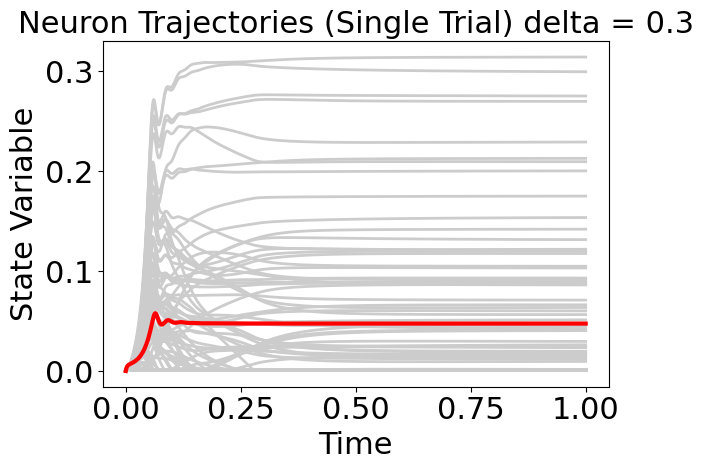

In [60]:
for neuron in range(N):
    plt.plot(t_chunk.numpy(), traj[:, neuron].detach().numpy(), linewidth=2.0,
             label=f'Neuron {neuron}', color="0.8")

# Compute the L2 norm across neurons for each time point and plot in red
# (Assumes traj is a 2D tensor with shape [time, neurons])
avg_traj = torch.mean(traj, dim=1)
plt.plot(t_chunk.numpy(), avg_traj.detach().numpy(), linewidth=3.0, color="red", label='Norm')

plt.xlabel("Time", fontsize=22)
plt.ylabel("State Variable", fontsize=22)
plt.title(f"Neuron Trajectories (Single Trial) delta = {delta}", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# Limit number of ticks for clarity
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

plt.tight_layout()

# Save the figure (adjust the folder and file names as needed)
folder_loc = f'../figures/mu_{mu}/fig_neuron_trajectories'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'neuron_trajectories_single_trial_{delta}'
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()